## 1. Import Libraries

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import joblib
import warnings
warnings.filterwarnings("ignore")

## 2. Load Train and Test Data

In [2]:
# Carga los datos desde los archivos guardados
X_train = np.load("data/X_train.npy")
y_train = np.load("data/y_train.npy")
X_test = np.load("data/X_test.npy")
y_test = np.load("data/y_test.npy")
scaler = joblib.load("data/scaler.pkl")
dates = np.load("data/dates.npy")
train_close_len = np.load("data/train_close_len.npy")

## 3. Design of Classical Models

In [3]:
def evaluate_model(name, model, X_tr, y_tr, X_te, y_te):
    t0 = time.time()
    model.fit(X_tr, y_tr)
    fit_time = time.time() - t0

    t1 = time.time()
    y_pred = model.predict(X_te)
    pred_time = time.time() - t1

    y_pred_descaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test_descaled   = scaler.inverse_transform(y_te.reshape(-1, 1))

    mse = mean_squared_error(y_test_descaled, y_pred_descaled)
    mae = mean_absolute_error(y_test_descaled, y_pred_descaled)
    rmse = np.sqrt(mse)

    print(f"\nModelo: {name}")
    print(f"Tiempo de Entrenamiento: {fit_time:.2f} seg")
    print(f"Tiempo de Predicción:   {pred_time:.2f} seg")
    print(f"MSE:  {mse:.6f}")
    print(f"MAE:  {mae:.6f}")
    print(f"RMSE: {rmse:.6f}")
    return y_pred, mse, mae, rmse

In [4]:
# Instanciar modelos con parámetros simples (sin gridsearch para acelerar)
# KNeighborsRegressor: se usa n_jobs=8 para paralelización
knn = KNeighborsRegressor(n_neighbors=5, n_jobs=8)
linreg = LinearRegression()
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=8)
svr = SVR(kernel='rbf', C=1.0)

pred_knn, mse_knn, mae_knn, rmse_knn = evaluate_model("KNN", knn, X_train, y_train, X_test, y_test)
pred_lin, mse_lin, mae_lin, rmse_lin = evaluate_model("LinearRegression", linreg, X_train, y_train, X_test, y_test)
pred_rf,  mse_rf,  mae_rf,  rmse_rf  = evaluate_model("RandomForest", rf, X_train, y_train, X_test, y_test)
pred_svr, mse_svr, mae_svr, rmse_svr = evaluate_model("SVR", svr, X_train, y_train, X_test, y_test)


Modelo: KNN
Tiempo de Entrenamiento: 0.01 seg
Tiempo de Predicción:   1.20 seg
MSE:  162891150.665107
MAE:  6335.519251
RMSE: 12762.881754

Modelo: LinearRegression
Tiempo de Entrenamiento: 0.22 seg
Tiempo de Predicción:   0.00 seg
MSE:  122439.399451
MAE:  211.014918
RMSE: 349.913417

Modelo: RandomForest
Tiempo de Entrenamiento: 320.68 seg
Tiempo de Predicción:   0.03 seg
MSE:  139203281.253918
MAE:  4920.396825
RMSE: 11798.444018

Modelo: SVR
Tiempo de Entrenamiento: 0.09 seg
Tiempo de Predicción:   0.01 seg
MSE:  615547763.754134
MAE:  14091.032190
RMSE: 24810.235060


In [5]:
# =============================================================================
# 2. Desescalar predicciones y y_test para visualizarlas en USDT
# =============================================================================
pred_knn_descaled = scaler.inverse_transform(pred_knn.reshape(-1, 1))
pred_lin_descaled = scaler.inverse_transform(pred_lin.reshape(-1, 1))
pred_rf_descaled  = scaler.inverse_transform(pred_rf.reshape(-1, 1))
pred_svr_descaled = scaler.inverse_transform(pred_svr.reshape(-1, 1))
y_test_descaled   = scaler.inverse_transform(y_test.reshape(-1, 1))

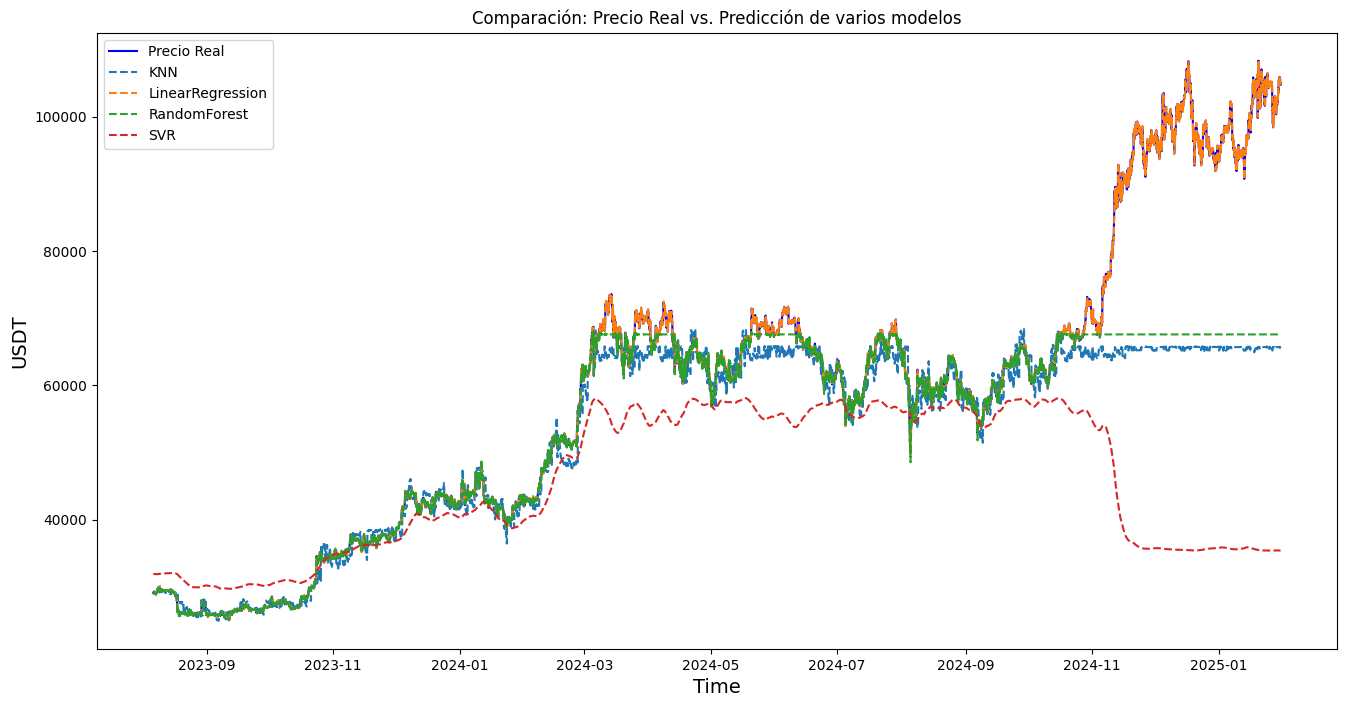

In [6]:
# Fechas del test (a partir de train_close_len)
dates_test = dates[train_close_len:]

plt.figure(figsize=(16, 8))
plt.title("Comparación: Precio Real vs. Predicción de varios modelos")
plt.xlabel("Time", fontsize=14)
plt.ylabel("USDT", fontsize=14)

# Precio real
plt.plot(dates_test, y_test_descaled, label="Precio Real", color="blue")

# KNN
plt.plot(dates_test, pred_knn_descaled, label="KNN", linestyle="--")

# Regresión Lineal
plt.plot(dates_test, pred_lin_descaled, label="LinearRegression", linestyle="--")

# Random Forest
plt.plot(dates_test, pred_rf_descaled, label="RandomForest", linestyle="--")

# SVR
plt.plot(dates_test, pred_svr_descaled, label="SVR", linestyle="--")

plt.legend(loc="best")
plt.show()


Resumen de resultados:
              Modelo           MSE           MAE          RMSE
0               KNN  1.628912e+08   6335.519251  12762.881754
1  LinearRegression  1.224394e+05    211.014918    349.913417
2      RandomForest  1.392033e+08   4920.396825  11798.444018
3               SVR  6.155478e+08  14091.032190  24810.235060


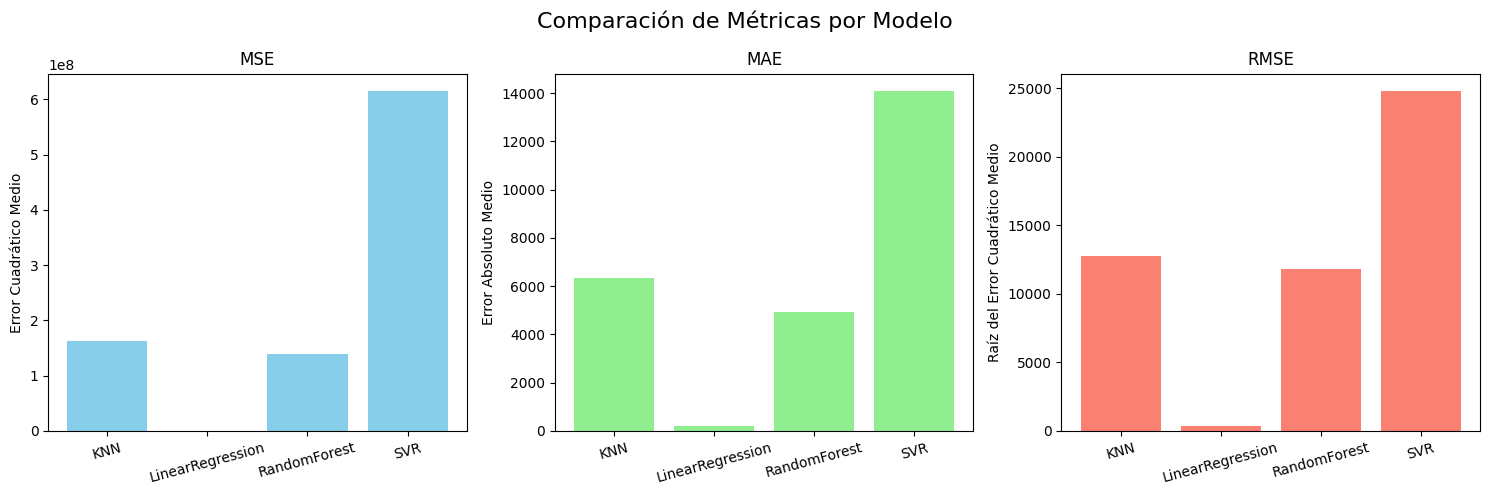

In [7]:
results = pd.DataFrame({
    "Modelo": ["KNN", "LinearRegression", "RandomForest", "SVR"],
    "MSE":  [mse_knn, mse_lin, mse_rf, mse_svr],
    "MAE":  [mae_knn, mae_lin, mae_rf, mae_svr],
    "RMSE": [rmse_knn, rmse_lin, rmse_rf, rmse_svr]
})
print("\nResumen de resultados:\n", results)

# =============================================================================
# 1. Visualizar las métricas en subplots
# =============================================================================
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# MSE
axs[0].bar(results['Modelo'], results['MSE'], color='skyblue')
axs[0].set_title('MSE')
axs[0].set_ylabel('Error Cuadrático Medio')
axs[0].set_xticklabels(results['Modelo'], rotation=15)

# MAE
axs[1].bar(results['Modelo'], results['MAE'], color='lightgreen')
axs[1].set_title('MAE')
axs[1].set_ylabel('Error Absoluto Medio')
axs[1].set_xticklabels(results['Modelo'], rotation=15)

# RMSE
axs[2].bar(results['Modelo'], results['RMSE'], color='salmon')
axs[2].set_title('RMSE')
axs[2].set_ylabel('Raíz del Error Cuadrático Medio')
axs[2].set_xticklabels(results['Modelo'], rotation=15)

plt.suptitle("Comparación de Métricas por Modelo", fontsize=16)
plt.tight_layout()
plt.show()